# Домашнее задание 4. Конструирование текстовых признаков из твитов пользователей

## Сбор данных

Первый этап - сбор твитов пользователей. Необходимо подключаться к Twitter API и запрашивать твиты по id пользователя. 
Подключение к API подробно описано в ДЗ 1.

In [1]:
import twitter
import time

In [2]:
CONSUMER_KEY = "key"
CONSUMER_SECRET = "secret"

ACCESS_TOKEN_KEY = "token_key"
ACCESS_TOKEN_SECRET = "token_secret"

api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET,
                  sleep_on_rate_limit = False)  # NOTE: " = True" results in quite messed up behaviour 

Для получения твитов пользователя может быть использован метод GetUserTimeline из библиотеки python-twitter. Он позволяет получить не более 200 твитов пользователя. По каждому пользователю достаточно собрать 200 твитов.

Метод имеет ограничение по количеству запросов в секунду. Для получения информации о промежутке времени, которое необходимо подождать для повторного обращения к API может быть использован метод `GetSleepTime`. Для получения информации об ограничениях запросов с помощью метода `GetUserTimeLine` необходимо вызывать `GetSleepTime` с параметром "statuses/user_timeline".

Метод GetUserTimeline возвращает объекты типа Status. У этих объектов есть метод AsDict, который позволяет представить твит в виде словаря.

Id пользователей необходимо считать из файла, как было сделано в ДЗ 1.

Необходимо реализовать функцию `get_user_tweets(user_id)`. Входной параметр - id пользователя из файла. Возвращаемое значение - массив твитов пользователя, где каждый твит представлен в виде словаря. Предполагается, что информация о пользователе содержится в твитах, которые пользователь написал сам. Это означает, что можно попробовать отфильтровать ответы другим пользователям, ссылки и ретвиты, а так же картинки и видео, так как наша цель - найти текстовую информацию.

In [3]:
def fetch_statuses(user_id, max_id = None, exclude_reactions = False):
    # Note: with reliable "sleep_on_rate_limit=True"-option implementation instead of default one
    
    MAX_ALLOWED_STATUSES_COUNT = 200
    while True:
        try:
            return api.GetUserTimeline(user_id = user_id,
                                       max_id = max_id,
                                       count = MAX_ALLOWED_STATUSES_COUNT,
                                       include_rts = not exclude_reactions,
                                       trim_user = True,
                                       exclude_replies = exclude_reactions)
        except twitter.TwitterError as e:
            # NOTE: yeah, various TwitterErrors are raised in different formats...
            if e.message == 'Not authorized.':
                return []
            elif e.message[0]['message'] == 'Sorry, that page does not exist.':
                return []            
            elif e.message[0]['message'] == 'Rate limit exceeded':
                print '.',
                time.sleep(180) # wait 3 minutes
            else:
                raise

def get_more_statuses(user_id, max_id = None):
    statuses = fetch_statuses(user_id, max_id, exclude_reactions = True)
    # NOTE: simplified -- drop user who has 200 retweets in a row
    return statuses          
    
def get_user_tweets(user_id, enough_tweets = 200): 
    # enough_tweets = 200 will take ~ 7 hours
    # enough_tweets = None (means get all available tweets) will take ~ 23 hours
    
    """returns list of tweets as dicts"""  
    tweets = []
    
    max_id = None
    while enough_tweets == None or len(tweets) < enough_tweets:
        statuses = get_more_statuses(user_id, max_id)
        if not statuses:
            break
            
        max_id = statuses[-1].id - 1
        
        # filter tweets with links or media
        for st in statuses:
            if not (st.media or st.urls):
                tweets.append({'lang': st.lang, 
                               'favorited': st.favorited, 
                               'truncated': st.truncated, 
                               'text': st.text, 
                               'created_at': st.created_at, 
                               'retweeted': False, # fetched with exclude_rts = True 
                               'source': st.source, 
                               'user': {'id': st.user.id}, 
                               'id': st.id})
                if len(tweets) == enough_tweets:
                    break
    return tweets
    '''return [{'lang': u'en', 
             'favorited': False, 
             'truncated': False, 
             'text': u"So now I'm on the floor tweeting about it PROB w a black eye n swollen nose", 
             'created_at': u'Mon Apr 06 05:59:50 +0000 2015', 
             'retweeted': False, 
             'source': u'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>', 
             'user': {'id': 984121344}, 
             'id': 584958674528964608}]
    '''
    
#print len(get_user_tweets(984121344))

## Разбор текста твита

Обработка текста предполагает разбиение текста на отдельные элементы - параграфы, предложения, слова. Мы будем преобразовывать текст твита к словам. Для этого текст необходимо разбить на слова. Сделать это можно, например, с помощью регулярного выражения.

Необходимо реализовать функцию, `get_words(text)`. Входной параметр - строка с текстом. Возвращаемое значение - массив строк (слов). Обратите внимание, что нужно учесть возможное наличие пунктуации и выделить по возможности только слова. 

In [4]:
import nltk

In [5]:
def get_words(text):
    """returns list of words"""
    tokenizer = nltk.WordPunctTokenizer() # which is RegexpTokenizer('\w+|[^\w\s]+')
    return map(lambda s: s.lower(), filter(lambda s: s.isalpha(), tokenizer.tokenize(text)))

In [6]:
print get_words("Here're, different words!")

['here', 're', 'different', 'words']


Далее полученные слова необходимо привести к нормальной форме. То есть привести их к форме единственного числа настоящего времени и пр. Сделать это можно с помощью библиотеки nltk. Информацию по загрузке, установке библиотеки и примерах использования можно найти на сайте http://www.nltk.org/

Для загрузки всех необходимых словарей можно воспользоваться методом download из библиотеки nltk.

In [7]:
#import nltk
#nltk.download()

Для дальнейшей обработки слова должны быть приведены к нижнему регистру. 

Для приведения к нормальной форме можно использовать `WordNetLemmatizer` из библиотеки nltk. У этого класса есть метод `lemmatize`.

Также необходимо убрать из текста так называемые стоп-слова. Это часто используемые слова, не несущие смысловой нагрузки для наших задач. Сделать это можно с помощью `stopwords` из nltk.corpus

Необходимо реализовать функцию `get_tokens(words)`. Входной параметр - массив слов. Возвращаемое значение - массив токенов.

In [8]:
my_stop_words = nltk.corpus.stopwords.words()

def get_tokens(words):
    """returns list of tokens"""
    sw = my_stop_words # improves performance
    return [nltk.WordNetLemmatizer().lemmatize(w) for w in words if w != 's' and w not in sw]
    # return ['different', u'word']

In [9]:
print get_tokens(["here", "s", "are", "different", "words"])
print 'I'in my_stop_words

['different', u'word']
False


Необходимо реализовать функцию `get_tweet_tokens(tweet)`. Входной параметр - текст твита. Возвращаемое значение -- токены твита. 

In [10]:
def get_tweet_tokens(tweet):
    return get_tokens(get_words(tweet))
    #return ['different', u'word']

Необходимо реализовать функцию `collect_users_tokens()`. Функция должна сконструировать матрицу признаков пользователей. В этой матрице строка - пользователь. Столбец - токен. На пересечении - сколько раз токен встречается у пользователя.
Для построения матрицы можно использовать `DictVectorizer` из `sklearn.feature_extraction`.

In [11]:
from collections import defaultdict
import json
import os
import pandas as pd

In [12]:
def load_file(handler, fname):
    if os.path.exists(fname):
        with open(fname, 'r') as f:
            for line in f:
                try:
                    handler(line)
                except Exception as ex:
                    print '[WRN] Bad line "{}" in file {}'.format(line, fname)
                    raise

def dump_json(obj, fname):
    with open(fname, 'a') as f:
        json.dump(obj, f)
        f.write('\n');
              
def collect_users_tokens(df_users):
    """returns users list and list of user dicts. Each dict contains frequence of user tokens"""
    
    # successfully collected tokens
    uids, tokenfreqs = [], []
    def load_collected_tokens(line):
        entry = json.loads(line)
        uids.append(entry['uid'])
        tokenfreqs.append(entry['tf'])     
    load_file(load_collected_tokens, 'collected_tokens')

    # can not gather any tweets from this uids
    bad_uids = []
    def load_bad_uids(line):
        bad_uids.append(json.loads(line))
    load_file(load_bad_uids, 'bad_uids')
    
    # load tweets for remaining uids
    remaining_uids = [int(user_id) for user_id in df_users['uid'] if user_id not in uids and user_id not in bad_uids]
    for i, user_id in enumerate(remaining_uids):
        # build tokens dict
        tf = defaultdict(int)
        print '<',
        for tweet in get_user_tweets(user_id, 200):
            print '>',
            for token in get_tweet_tokens(tweet['text']):
                tf[token] += 1                  
        if tf:
            dump_json(dict({'uid': int(user_id), 'tf': tf}), 'collected_tokens')
        else:
            dump_json(user_id, 'bad_uids')
        print '\r', i,

    
    return uids, tokenfreqs
    #return [12345], [{u'eye': 1, u'floor': 1, u'tweeting': 1, u'n': 1, u'black': 1, u'nose': 1, u'w': 1, u'swollen': 1, u"i'm": 1, u'prob': 1}]


In [13]:
from sklearn.feature_extraction import DictVectorizer

TRAINING_SET_URL = 'train.csv' #"twitter_train.txt"
EXAMPLE_SET_URL = 'test.csv' #"twitter_example.txt"
df_users_train = pd.read_csv(TRAINING_SET_URL, sep=",", header=0, names=["uid", "cat"])
df_users_ex = pd.read_csv(EXAMPLE_SET_URL, sep=",", header=0, names=["uid"])
df_users_ex['cat'] = None
df_users = pd.concat([df_users_train, df_users_ex])

users, users_tokens = collect_users_tokens(df_users)
v = DictVectorizer()
vs = v.fit_transform(users_tokens)

Сохраним полученные данные в файл. Используется метод savez из numpy. 

In [14]:
import numpy as np
np.savez("out_4.dat", data=vs, users=users, users_tokens=users_tokens )

Далее для получения представления о полученной информацию о токенах предлагается отобразить ее в виде облака тэгов. [Подсказка](http://anokhin.github.io/img/tag_cloud.png). 

In [15]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline

C:\Anaconda2\lib\site-packages\ipykernel\pylab\config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
C:\Anaconda2\lib\site-packages\ipykernel\pylab\config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
C:\Anaconda2\lib\site-packages\ipykernel\pylab\config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
C:\Anaconda2\lib\site-packages\ipykernel\pylab\config.py:95: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='v

C:\Anaconda2\lib\site-packages\IPython\core\formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
C:\Anaconda2\lib\site-packages\IPython\core\formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


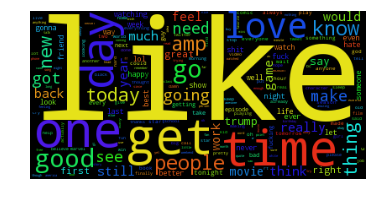

In [16]:
def draw_tag_cloud(v, vs):
    """Draws tag cloud of found tokens"""
    tuples = [(token, vs.getcol(i).sum()) for i,token in enumerate(v.get_feature_names())]
    wordcloud = WordCloud().generate_from_frequencies(tuples)
    plt.imshow(wordcloud)
    plt.axis("off")
    return

draw_tag_cloud(v, vs)